In [6]:
import os
import sys
sys.path.insert(0, os.path.abspath('../model'))
import imp

import pandas as pd
import matplotlib.pyplot as plt
from os import listdir
from os.path import isfile
import numpy as np
import seaborn as sns
import networkx as nx
import json
import scipy.special

import aux
imp.reload(aux)
import graph_manager
imp.reload(graph_manager)

<module 'graph_manager' from '/Volumes/GoogleDrive/Altri computer/Il mio computer/GoogleDrive/Laboratorio/Humans account for cognitive costs when finding shortcuts/model/graph_manager.py'>

In [7]:
data_path = "../data/Experiment2/" # path to experiment data - you can obtain the data at https://osf.io/ykxts/ and place the Experiment2 folder in the data folder

Each file is named ParticipantNumber_Group_Gender_etc.txt. These info can be found inside the file too.

Lines starting with "!" which the start-goal locations of that trial.

There are N rows with 5 columns each (separated by a comma), representing:
time, x Position, y Position, angle, box_x, box_y

With the last two a discretization of the coordinates (however we rediscretized it differently).

Notice that our box_x and box_y are not the same as the ones in the original data files

In [8]:
skiprows = 9    # number of rows to skip at the beginning of each data files, usually 9 (contain metadata)
box_size = 8.   # maps are tasselated with 8x8 boxes

In [9]:
# read and preprocess all experiment files in the data_path folder (can be used on Exp 1 as well)

DF = pd.DataFrame()
for filename in np.sort(listdir(data_path)):
    if isfile(data_path+filename):
        
        df = aux.openExpFile(data_path+filename,skiprows,box_size=box_size)
        print(filename,len(df),end="\r")
        DF = DF.append(df)

DF = DF[~((DF.subject=="319_gtg_a1") & (DF.exp_type==2) & (DF.trial==20) & (DF.dsp_goal==13))] # unfinished trial or wrong goal, we removed the trial

In [10]:
if not os.path.exists("../data/processed/"):
    os.makedirs("../data/processed/")
DF.to_csv("../data/processed/experiment2.csv") # save the processed data to a csv file for later use

In [12]:
# notice that our box_x and box_y are not the same as the ones in the original data files
# exp_type 1 and 2 represents the map and its mirrored version respectively


DF.head()

,subject,trial,exp_type,dsp_goal,time,x,y,angle,box_x,box_y
0,301_gtg_a,1,1,18,0.02,50.89999,191.8,6.200026,6,24
1,301_gtg_a,1,1,18,0.03,50.89999,191.8,6.200026,6,24
2,301_gtg_a,1,1,18,0.05,50.89999,191.8,6.200026,6,24
3,301_gtg_a,1,1,18,0.07,50.89999,191.8,6.200026,6,24
4,301_gtg_a,1,1,18,0.08,50.89999,191.8,6.200026,6,24


In [13]:
print("Number of unique subjects (counts subjects twice): ", len(DF.subject.unique()))
print("Number of unique start-goal conditions: ",len(DF.dsp_goal.unique()))
print("Number of unique trials: ",len(DF[["subject","dsp_goal"]].drop_duplicates().values))
print("Average sampling rate [Hz]: ",np.round(1./np.nanmean([dt if dt > 0 else np.nan for dt in DF.time.diff()]),2))
print("Max time [s]: ",np.round(DF.time.max(),2))

#trials are cut at 40 seconds

Number of unique subjects (counts subjects twice):  160
Number of unique start-goal conditions:  20
Number of unique trials:  3199
Average sampling rate [Hz]:  59.92
Max time [s]:  40.0


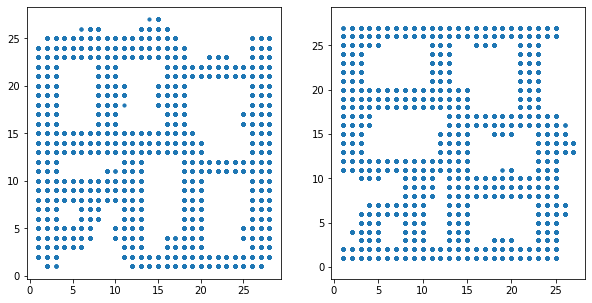

In [14]:
#plot the tasselated map and its mirrored version - subjects are asked to navigate in both version (exp_type 1 and 2)

plt.figure(figsize=(10,5))

plt.subplot(121)
plt.scatter(DF[DF.exp_type==1].box_x,DF[DF.exp_type==1].box_y,s=10)
plt.subplot(122)
plt.scatter(DF[DF.exp_type==2].box_x,DF[DF.exp_type==2].box_y,s=10)

plt.axis("equal")
plt.show()

We used subjects occupancies in both versions to reconstruct the maps as 8x8 boxes. Then we added the missing (i.e. never occupied) boxes to replicate the map picture in the original paper.

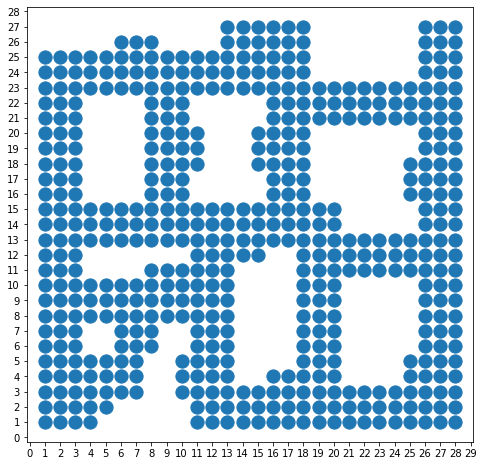

In [15]:
xs = DF[DF.exp_type==1].box_x
xs = xs.append(DF[DF.exp_type==2].box_y)

ys = DF[DF.exp_type==1].box_y
ys = ys.append(DF[DF.exp_type==2].box_x)

nodes = np.unique(np.array([xs,ys]).T,axis=0)

nodes = np.append(nodes,[[4,1],[5,2],[28,1],[7,3],[16,27],[17,26],[17,27],
                              [18,25],[18,26],[18,27],[26,26],[26,27],[27,26],[27,27],
                              [28,26],[28,27]] ,axis=0) # add the 16 nodes that are missing from the tasselated map

plt.figure(figsize=(8,8))
plt.scatter(nodes[:,0],nodes[:,1],s=700,marker=".")

plt.xticks(range(30))
plt.yticks(range(30))
plt.axis("equal")
plt.show()


We used networkx to represent the map as a graph. The "G" variable is a networkx graph at which we added the following attributes:
- "pos" which is a dictionary of the form {node: (x,y)}
- start and goals (unused)
- grid_height and grid_width (unused) 

This is an intermediate representation of the map with 507 nodes.

In [16]:
# loads the graph of the tasselated map
G = graph_manager.load_graph(filename="map_low.json",filedir="../data/processed/")
len(G)

507

To create the final version of the map, we firstly used sklearn.cluster.KMeans over the node positions to find a first raw estimate of the 66 "clusters" (from 507). 

Then we refined by hand the labels to create the 66 final nodes of the map. 

The nodes were clustered so that they were roughly similar in area and could be linked by horizontal or vertical paths.

In [17]:
# loads the 66 labels for the old 507 nodes in the graph
with open('../data/processed/node_labels.json', 'r') as f:
    labels = json.load(f)

In [18]:
# loads the new refined 66 nodes graph
H = graph_manager.load_graph(filename="map_high.json",filedir="../data/processed/")

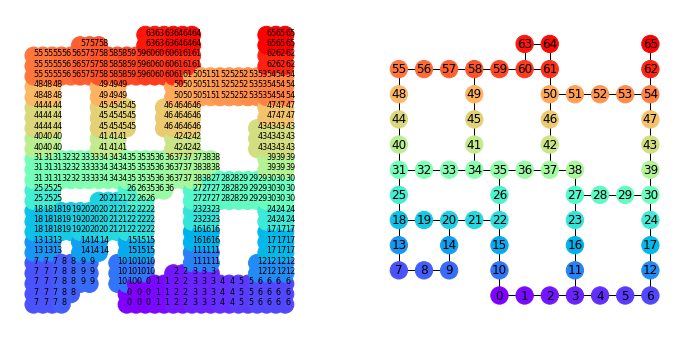

In [19]:
# a side by side comparison of the two graphs

plt.figure(figsize=(12,6))

plt.subplot(121)
nx.draw(G,G.pos,node_color=labels,cmap="rainbow")
for i,l in enumerate(labels):
    plt.text(G.pos[i][0],G.pos[i][1],l,size=8)

plt.subplot(122)
nx.draw(H, H.pos,with_labels=True,node_color=list(H.pos.keys()),cmap="rainbow")


plt.axis("equal")
plt.show()

We created a default policy for the map, in the form of a list of 66 lists (distributions) of 4 floats (summing to one), one for each of the 4 cardinal directions. The policy is deterministic* (e.g.:[0,1,0,0]) over the path learned by the subjects, and flat ([0.25,0.25,0.25,0.25]) elsewhere.

*For convergence reasons, in the following notebooks we slightly flattened the deterministic policy, so that it is not exactly [0,1,0,0] but the peak is 0.999 instead.

In [30]:
default_policy = np.loadtxt("../data/processed/default_policy.txt")

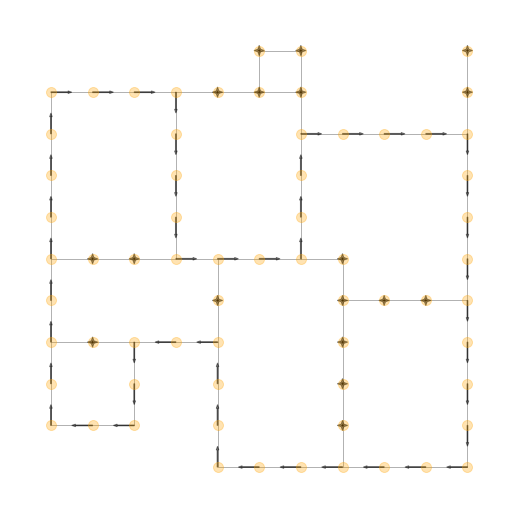

In [21]:
plt.figure(figsize=(7,7))
nx.draw(H,H.pos,node_size=100,alpha=0.3,node_color="orange")

direction_vector = {0:(0,1), 1:(1,0), 2:(0,-1), 3:(-1,0)}

for node,(x,y) in H.pos.items():
    for action_id,module in enumerate(default_policy[node]):
        dx,dy = direction_vector[action_id]
        plt.arrow(x,y,dx*module*0.5,dy*module*0.5,color="k",zorder=0,
                        length_includes_head=True,width=0.02, alpha=0.5)
plt.axis("equal")
plt.show()

Additionally, we associated each trial number to the average start and goal position, you can find it in data/processed/start_goal_positions.csv